# Host QC

In [8]:
bp = "PRJNA665227"
fastq_folder = f"/home/laura/projects/virus-watch-data/{bp}"

In [9]:
import kb_python.utils as kb_utils
import numpy as np
from scipy.interpolate import interpn
import pandas as pd
import gget
import json
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
%config InlineBackend.figure_format='retina'

import scanpy as sc
sc.set_figure_params(figsize=(6, 6), frameon=False)
sc.settings.n_jobs=2

# Path to Krona tool
ktImportText = "/home/laura/bin/ktImportText"

def nd(arr):
    """
    Function to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

### Load data aligned to host (macaque) and canine (for MDCK spike-ins) genomes:

In [10]:
%%time
# Filepath to counts
X = f"{fastq_folder}/full_index_stringent_dlist_flank1/host_canine/bustools_count/output.mtx"
# Filepath to barcode metadata
var_path = f"{fastq_folder}/full_index_stringent_dlist_flank1/host_canine/bustools_count/output.genes.txt"
# Filepath to gene metadata
obs_path = f"{fastq_folder}/full_index_stringent_dlist_flank1/host_canine/bustools_count/output.barcodes.txt" 

# Create AnnData object
host_adata = kb_utils.import_matrix_as_anndata(X, obs_path, var_path)
host_adata

/home/laura/anaconda3/lib/python3.9/site-packages/kb_python/utils.py:673: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  anndata.AnnData(X=mtx.tocsr(), obs=df_barcodes, var=df_genes)


CPU times: user 6min 9s, sys: 18.6 s, total: 6min 27s
Wall time: 6min 23s


AnnData object with n_obs × n_vars = 37282948 × 66553

In [11]:
# Add sample barcodes to adata
sb_file = open(f"{fastq_folder}/full_index_stringent_dlist_flank1/host_canine/bustools_count/output.barcodes.prefix.txt")
sample_barcodes = sb_file.read().splitlines() 
sb_file.close()

# Only use last 16 bases because sample barcode is always 16 bases in length
host_adata.obs["sample_barcode"] = [bc[-16:] for bc in sample_barcodes]

In [12]:
# Create barcode to sample lookup
bc2sample_df = pd.DataFrame()

b_file = open(f"{fastq_folder}/full_index_stringent_dlist_flank1/host_canine/matrix.sample.barcodes")
barcodes = b_file.read().splitlines() 
b_file.close()

s_file = open(f"{fastq_folder}/full_index_stringent_dlist_flank1/host_canine/matrix.cells")
samples = s_file.read().splitlines() 
s_file.close()

bc2sample_df["sample_barcode"] = barcodes
bc2sample_df["srr"] = samples
bc2sample_df

,sample_barcode,srr
0,AAAAAAAAAAAAAAAA,SRR12698516
1,AAAAAAAAAAAAAAAC,SRR12698524
2,AAAAAAAAAAAAAAAG,SRR12698536
3,AAAAAAAAAAAAAAAT,SRR12698560
4,AAAAAAAAAAAAAACA,SRR12698542
...,...,...
101,AAAAAAAAAAAACGCC,SRR12698577
102,AAAAAAAAAAAACGCG,SRR12698582
103,AAAAAAAAAAAACGCT,SRR12698514
104,AAAAAAAAAAAACGGA,SRR12698553


In [13]:
host_adata.obs["barcode"] = host_adata.obs.index.values
host_adata.obs = host_adata.obs.merge(bc2sample_df, on="sample_barcode", how="left").set_index("barcode", drop=False)
host_adata.obs

,sample_barcode,barcode,srr
barcode,,,
AAAAAAAAAAAA,AAAAAAAAAAAAAAAA,AAAAAAAAAAAA,SRR12698516
AAAAAAAACAGG,AAAAAAAAAAAAAAAA,AAAAAAAACAGG,SRR12698516
AAAAAAAAGACA,AAAAAAAAAAAAAAAA,AAAAAAAAGACA,SRR12698516
AAAAAAAATACA,AAAAAAAAAAAAAAAA,AAAAAAAATACA,SRR12698516
AAAAAAAATGCC,AAAAAAAAAAAAAAAA,AAAAAAAATGCC,SRR12698516
...,...,...,...
TTTTTTTTAGAA,AAAAAAAAAAAACGGC,TTTTTTTTAGAA,SRR12698550
TTTTTTTTAGCC,AAAAAAAAAAAACGGC,TTTTTTTTAGCC,SRR12698550
TTTTTTTTAGGA,AAAAAAAAAAAACGGC,TTTTTTTTAGGA,SRR12698550


In [14]:
# Remove version number from Ensembl IDs
host_adata.var["gene_id"] = host_adata.var.index.values
host_adata.var["ensembl_id"] = [id_.split(".")[0] for id_ in host_adata.var.index.values]
host_adata.var = host_adata.var.set_index("ensembl_id")
host_adata.var

,gene_id
ensembl_id,
ENSCAFG00845000002,ENSCAFG00845000002.1
ENSCAFG00845000003,ENSCAFG00845000003.1
ENSCAFG00845000004,ENSCAFG00845000004.1
ENSCAFG00845000005,ENSCAFG00845000005.1
ENSCAFG00845000006,ENSCAFG00845000006.1
...,...
ENSMMUG00000065243,ENSMMUG00000065243.1
ENSMMUG00000042754,ENSMMUG00000042754.2
ENSMMUG00000057512,ENSMMUG00000057512.1


___
# Filter host cells based on knee plot

In [15]:
color = "grey"
filter_color = "lightgrey"
fontsize = 14

# Expected number of cells
expected_num_cells = 600000
# Minimum number of genes per cell
min_genes = 300

In [16]:
def yex(ax, col="k", alpha=0.75):
    """
    Funciton to add linear graph to plot.
    Call after defining x and y scales
    """
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # Plot both limits against each other
    ax.plot(lims, lims, col, alpha=alpha, zorder=1)
    ax.set(**{
        "aspect": "equal",
        "xlim": lims,
        "ylim": lims
    })
    return ax

CPU times: user 3min 12s, sys: 13.5 s, total: 3min 26s
Wall time: 3min 24s


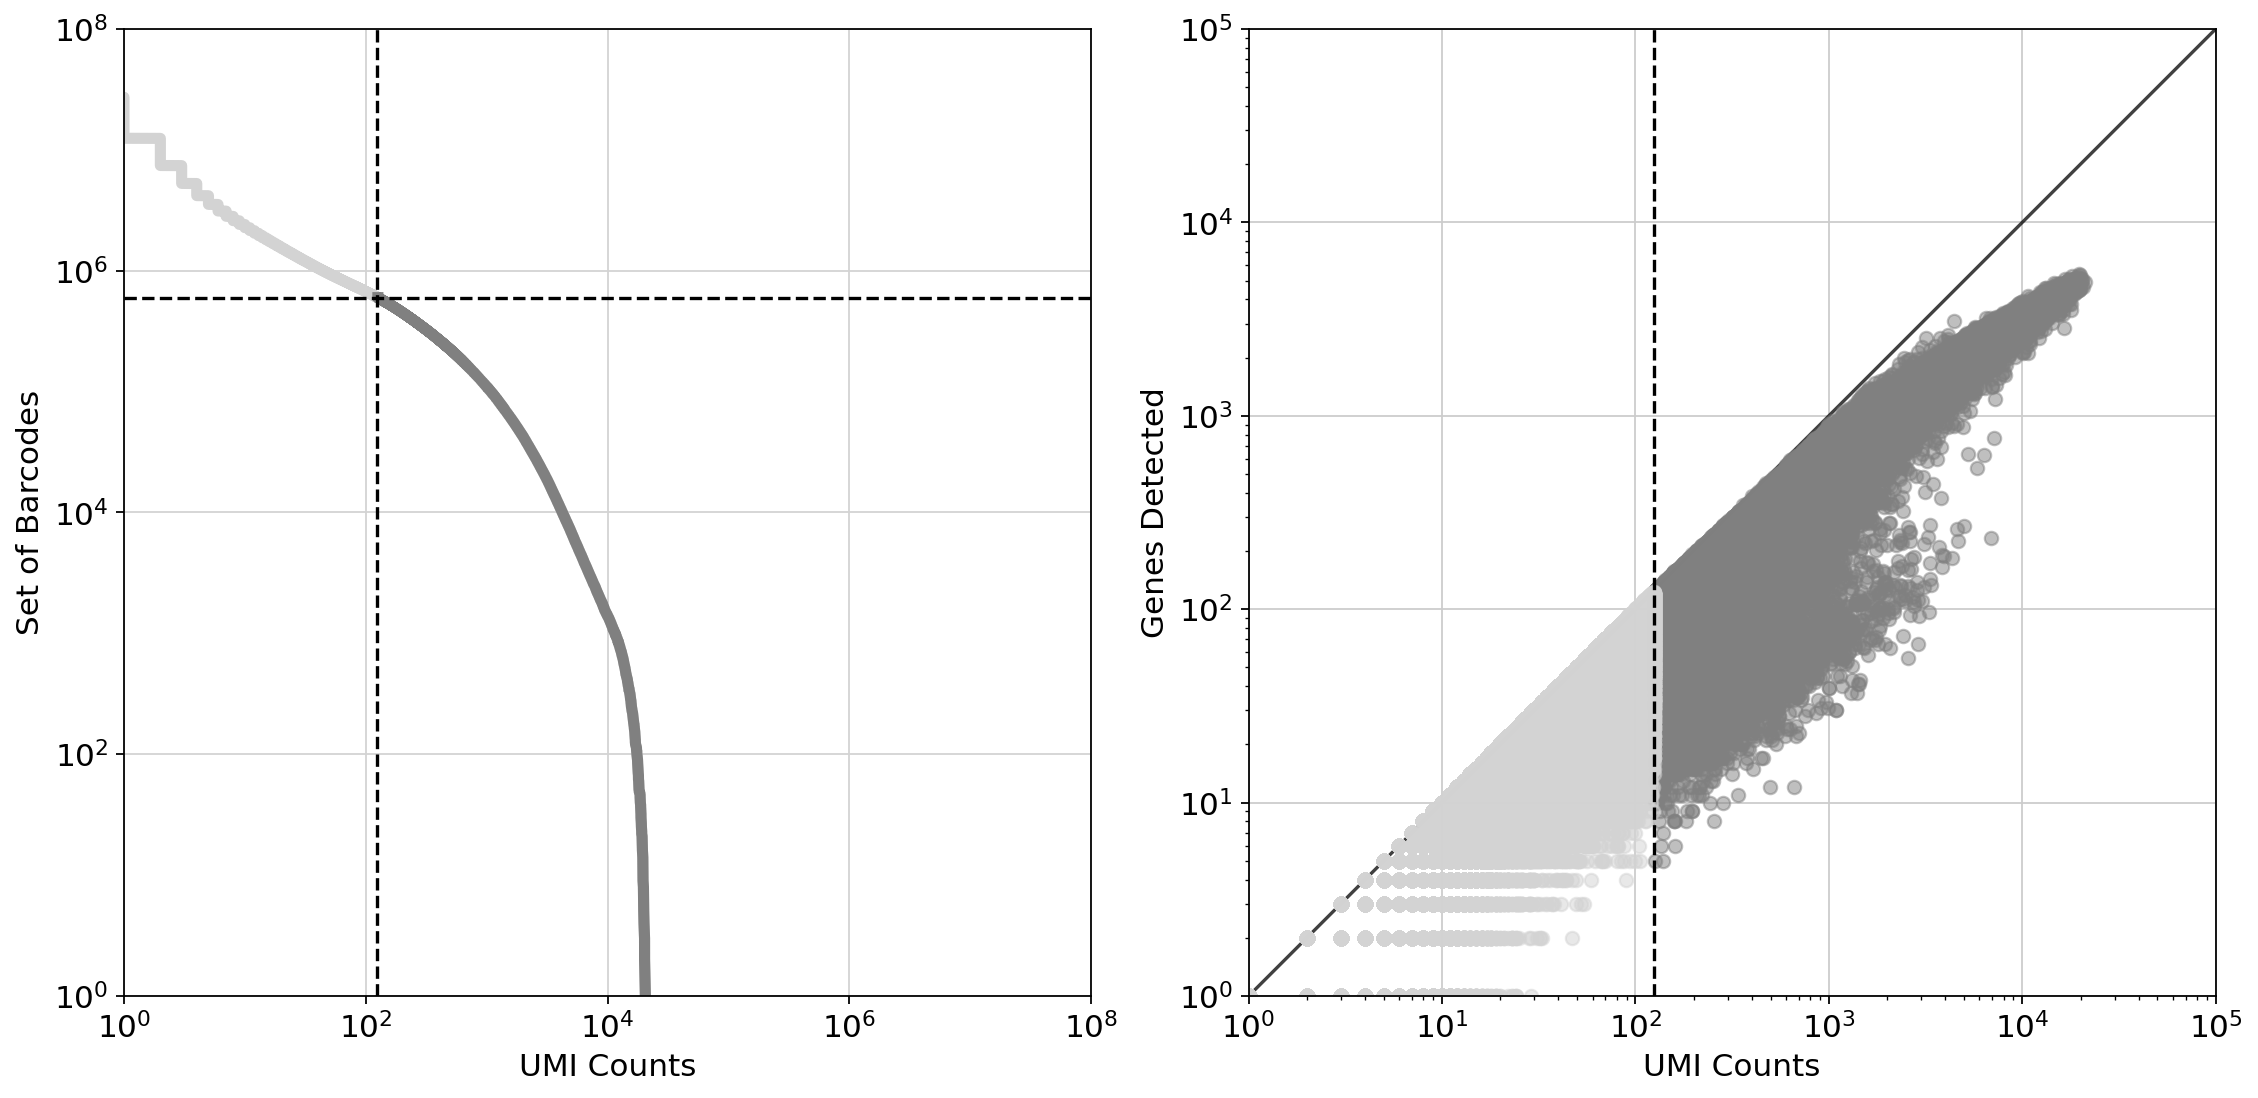

In [17]:
%%time
# Generate knee and library saturation plots
fig, axs = plt.subplots(
    figsize=(14, 7),
    ncols=2,
    constrained_layout=True,
)

adata = host_adata

## Plot knee plot
ax = axs[0]

knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

# Create masks for cells that will be kept/filtered out based on minimum UMI count
min_umi = knee[expected_num_cells]
keep_mask = np.ma.masked_where(knee > min_umi, knee).mask
filter_mask = np.invert(keep_mask)

# Plot all cells in filter out color
ax.plot(knee, range(len(knee)), linewidth=5, color=filter_color)
# Overlay with cells to keep in dark color
ax.plot(knee[keep_mask], range(len(knee[keep_mask])), linewidth=5, color=color)
ax.set_xscale("log")
ax.set_yscale("log")

# Add lines to show filtering cut offs
ax.axvline(x=knee[expected_num_cells], linewidth=1.5, color="k", ls="--")
ax.axhline(y=expected_num_cells, linewidth=1.5, color="k", ls="--")

# Define axis labels and title
ax.set_xlabel("UMI Counts", fontsize=fontsize)
ax.set_ylabel("Set of Barcodes", fontsize=fontsize)
# ax.set_title(title, fontsize=fontsize + 2)

# Change fontsize of tick labels
ax.tick_params(axis="both", labelsize=fontsize)

# # Set x and y lim 
ax.set_xlim(1, 10 ** 8)
ax.set_ylim(1, 10 ** 8)

# Add grid and set below graph
ax.grid(True, which="both", color="lightgray")
ax.set_axisbelow(True)

# Add invisible linear graph to match square library sat plot
yex(ax, alpha=0)


## Plot library saturation plot
ax = axs[1]

# Number of UMI counts per cell
x = np.asarray(adata.X.sum(axis=1))[:, 0]
# Number of different genes detected per cell
y = np.asarray(np.sum(adata.X > 0, axis=1))[:, 0]

# Create masks for cells that will be kept/filtered out based on minimum UMI count from knee plot
keep_mask = np.ma.masked_where(x > min_umi, x).mask
filter_mask = np.invert(keep_mask)

ax.scatter(x[keep_mask], y[keep_mask], alpha=0.5, color=color, zorder=2)
ax.scatter(x[filter_mask], y[filter_mask], alpha=0.5, color=filter_color, zorder=2)

# Add lines to show filtering cut off
ax.axvline(x=min_umi, linewidth=1.5, color="k", ls="--", zorder=3)

ax.set_xscale("log")
ax.set_yscale("log")

# Define axis labels and title
ax.set_xlabel("UMI Counts", fontsize=fontsize)
ax.set_ylabel("Genes Detected", fontsize=fontsize)
# ax.set_title(title, fontsize=fontsize+2)

# Change fontsize of tick labels
ax.tick_params(axis="both", labelsize=fontsize)

# # Set x and y lim
ax.set_xlim(1, 10 ** 5)
ax.set_ylim(1, 10 ** 5)

# Add grid and set below graph
ax.set_axisbelow(True)

# Add linear graph
yex(ax)

# Save figure
fig.savefig(
    f"figures/3.1_host_QC_knee_+_library_sat.png", dpi=300, bbox_inches="tight"
)

fig.show()

In [18]:
## Filter based on knee plot and minimum number of genes
print("adata (before filtering): ", host_adata)
print(f"Minimum number of UMI counts based on the knee plot: {min_umi}")
print(f"Mean UMI count per cell (before filtering): {host_adata.X.sum(axis=1).mean()}")
print(f"Max UMI count in one cell: {host_adata.X.sum(axis=1).max()}")
print(f"Total UMI count (before filtering): {host_adata.X.sum()}")

adata (before filtering):  AnnData object with n_obs × n_vars = 37282948 × 66553
    obs: 'sample_barcode', 'barcode', 'srr'
    var: 'gene_id'
Minimum number of UMI counts based on the knee plot: 125.0
Mean UMI count per cell (before filtering): 14.311197280883789
Max UMI count in one cell: 21053.0
Total UMI count (before filtering): 533563616.0


In [19]:
# Remove cells with less than [min_umi] UMI counts
host_adata = host_adata[np.asarray(host_adata.X.sum(axis=1)).reshape(-1) > min_umi]

# Add the total UMI counts per cell as obs to adata
host_adata.obs['n_counts'] = host_adata.X.sum(axis=1).A1

## Filter for a minimum number of genes
sc.pp.filter_cells(host_adata, min_genes=min_genes)

print(f"Mean UMI count per cell (after filtering): {host_adata.X.sum(axis=1).mean()}")
print(f"Total UMI count (after filtering): {host_adata.X.sum()}\n")

Mean UMI count per cell (after filtering): 1401.9990234375
Total UMI count (after filtering): 340161408.0



# Filter by mito content

In [20]:
# Max percentage mitochondrial genes per cell (10%)
mito_filter = 0.1

In [21]:
# Get macaque mito genes
# Get Ensembl IDs of MT genes
mito_ensembl_df = sc.queries.mitochondrial_genes("mmulatta", attrname="ensembl_gene_id")
macaca_mito_gene_ids = mito_ensembl_df["ensembl_gene_id"].values
macaca_mito_gene_ids

array(['ENSMMUG00000065381', 'ENSMMUG00000065373', 'ENSMMUG00000065363',
       'ENSMMUG00000065362', 'ENSMMUG00000065374', 'ENSMMUG00000065372',
       'ENSMMUG00000065384', 'ENSMMUG00000065364', 'ENSMMUG00000065370',
       'ENSMMUG00000065356', 'ENSMMUG00000065378', 'ENSMMUG00000065361',
       'ENSMMUG00000065352', 'ENSMMUG00000065367', 'ENSMMUG00000065385',
       'ENSMMUG00000065358', 'ENSMMUG00000065360', 'ENSMMUG00000065377',
       'ENSMMUG00000065380', 'ENSMMUG00000065376', 'ENSMMUG00000065383',
       'ENSMMUG00000065375', 'ENSMMUG00000065366', 'ENSMMUG00000065365',
       'ENSMMUG00000065353', 'ENSMMUG00000065369', 'ENSMMUG00000065379',
       'ENSMMUG00000065387', 'ENSMMUG00000065357', 'ENSMMUG00000065368',
       'ENSMMUG00000065388', 'ENSMMUG00000065354', 'ENSMMUG00000065359',
       'ENSMMUG00000065371', 'ENSMMUG00000065382', 'ENSMMUG00000065386',
       'ENSMMUG00000065355'], dtype=object)

In [22]:
# Get canine mito genes with gget
gget_df = gget.search(["MT", "mito"], andor="and", species="canis_lupus_familiaris_core_109_1")
gget_df = gget_df[(gget_df["biotype"] == "protein_coding") & (gget_df["gene_name"].str.startswith("MT"))]
canine_mito_gene_ids = gget_df["ensembl_id"].values
canine_mito_gene_ids

Thu Nov 30 18:57:30 2023 INFO Fetching results from database: canis_lupus_familiaris_core_109_1
Thu Nov 30 18:57:35 2023 INFO Total matches found: 25.
Thu Nov 30 18:57:35 2023 INFO Query time: 5.27 seconds.


array(['ENSCAFG00845000120', 'ENSCAFG00845005614', 'ENSCAFG00845008083',
       'ENSCAFG00845008387', 'ENSCAFG00845010197', 'ENSCAFG00845010861',
       'ENSCAFG00845011540', 'ENSCAFG00845012090', 'ENSCAFG00845012129',
       'ENSCAFG00845012213', 'ENSCAFG00845012616', 'ENSCAFG00845013602',
       'ENSCAFG00845016227', 'ENSCAFG00845018020', 'ENSCAFG00845018392',
       'ENSCAFG00845020087', 'ENSCAFG00845024367', 'ENSCAFG00845025671',
       'ENSCAFG00845026926', 'ENSCAFG00845030177'], dtype=object)

In [23]:
mito_gene_ids = list(macaca_mito_gene_ids) + list(canine_mito_gene_ids)

In [24]:
# `.A1` transforms sparse array X to a dense array after summing
host_adata.obs['percent_mito'] = np.sum(host_adata[:, mito_gene_ids].X, axis=1).A1 / np.sum(host_adata.X, axis=1).A1
print(f"Maximum % mitochondrially encoded genes in one cell (before filtering): {host_adata.obs.percent_mito.max()}.")
host_adata = host_adata[host_adata.obs.percent_mito < mito_filter]
print(f"Maximum % mitochondrially encoded genes in one cell (after filtering): {host_adata.obs.percent_mito.max()}.")

Maximum % mitochondrially encoded genes in one cell (before filtering): 0.6822549700737.
Maximum % mitochondrially encoded genes in one cell (after filtering): 0.09994848072528839.


___
# Separate macaque and MDCK cells

Add species label to genes:

In [25]:
def label_species(row):
    if row["gene_id"].startswith("ENSCAF"):
        return "canis_lupus_familiaris"
    elif row["gene_id"].startswith("ENSMM"):
        return "macaca_mulatta"
    else:
        return "unknown"

host_adata.var["species"] = host_adata.var.apply(lambda row: label_species(row), axis=1)

In [26]:
host_adata.var

,gene_id,species
ensembl_id,,
ENSCAFG00845000002,ENSCAFG00845000002.1,canis_lupus_familiaris
ENSCAFG00845000003,ENSCAFG00845000003.1,canis_lupus_familiaris
ENSCAFG00845000004,ENSCAFG00845000004.1,canis_lupus_familiaris
ENSCAFG00845000005,ENSCAFG00845000005.1,canis_lupus_familiaris
ENSCAFG00845000006,ENSCAFG00845000006.1,canis_lupus_familiaris
...,...,...
ENSMMUG00000065243,ENSMMUG00000065243.1,macaca_mulatta
ENSMMUG00000042754,ENSMMUG00000042754.2,macaca_mulatta
ENSMMUG00000057512,ENSMMUG00000057512.1,macaca_mulatta


In [27]:
host_adata.var["species"].unique()

array(['canis_lupus_familiaris', 'macaca_mulatta'], dtype=object)

In [28]:
host_adata

AnnData object with n_obs × n_vars = 237658 × 66553
    obs: 'sample_barcode', 'barcode', 'srr', 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_id', 'species'

Plot number of cells with shared gene expression and define cell species based on gene count threshold:

In [29]:
macaque_count = (np.array(host_adata[:, host_adata.var["species"] == "macaca_mulatta"].X.sum(axis=1))).flatten()

In [30]:
len(macaque_count[macaque_count > 0])

236816

In [31]:
canis_count = (np.array(host_adata[:, host_adata.var["species"] == "canis_lupus_familiaris"].X.sum(axis=1))).flatten()

In [32]:
len(canis_count[canis_count > 0])

234419

CPU times: user 1.93 s, sys: 70.8 ms, total: 2 s
Wall time: 2 s


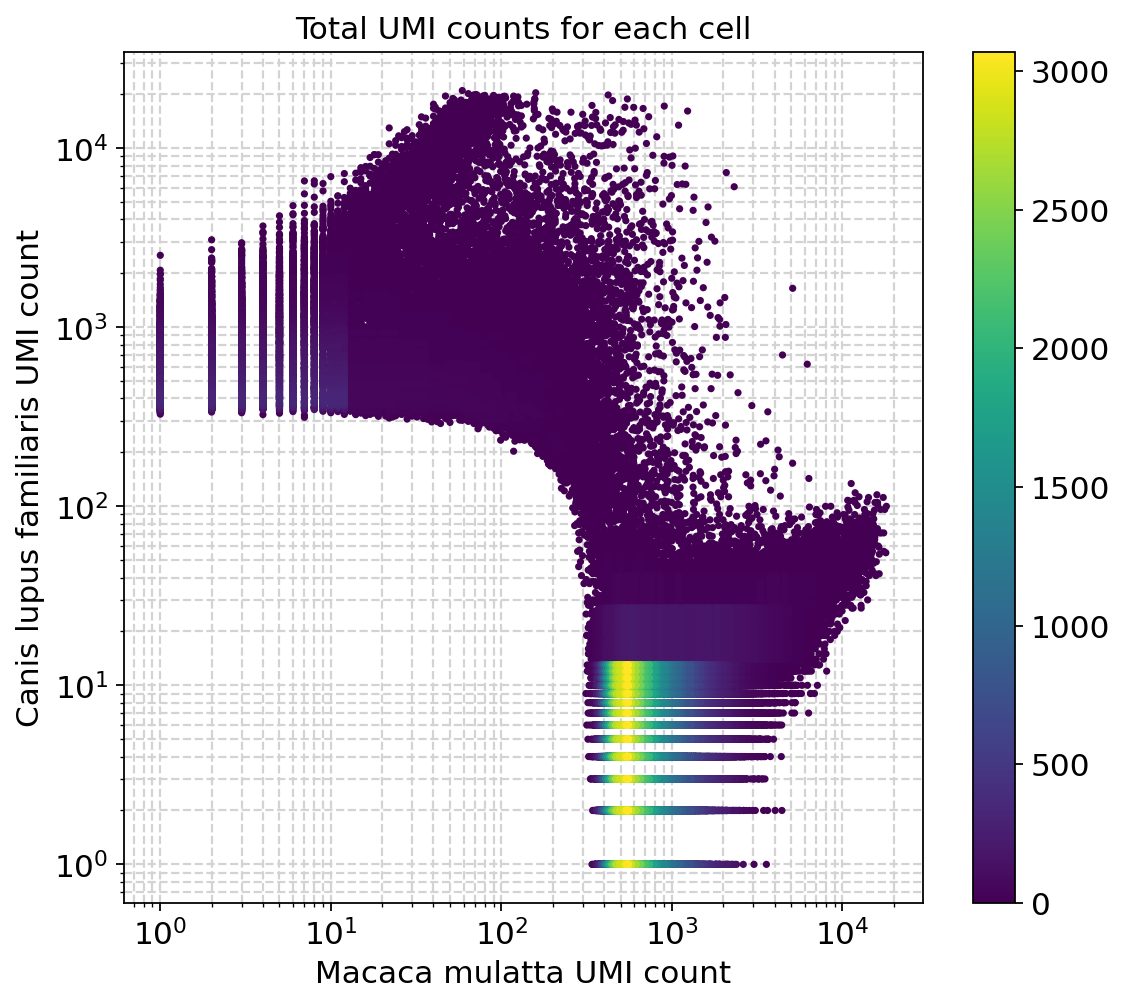

In [33]:
%%time
fig, ax = plt.subplots(figsize=(8, 7))

# Plot number of canis over macaque UMIs
x = macaque_count
y = canis_count

# Histogram data to show point density
bins = [1500, 1500]
hh, locx, locy = np.histogram2d(x, y, bins=bins)
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]
        
scatter = ax.scatter(x2, y2, c=z2, cmap="viridis", s=5)

# Add colorbar
fig.colorbar(scatter, ax=ax)

# # Add rectangles showing species filters
# threshold = 20

# p1 = mpatches.Rectangle((0, threshold), threshold, ax.get_ylim()[1] - threshold, alpha=0.1, facecolor="#f77f00")
# ax.add_patch(p1)
# p2 = mpatches.Rectangle((threshold, 0), ax.get_xlim()[1] - threshold, threshold, alpha=0.1, facecolor="green")
# ax.add_patch(p2)

ax.set_title("Total UMI counts for each cell")
ax.set_xlabel("Macaca mulatta UMI count")
ax.set_ylabel("Canis lupus familiaris UMI count")

ax.set_xscale("log")
ax.set_yscale("log")

ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
ax.set_axisbelow(True)

# # Save figure
# fig.savefig(
#     f"figures/3.1_canis_macaca_umis_2.png", dpi=300, bbox_inches="tight"
# )

fig.show()

In [34]:
# %%time
# # Define minimum UMI count for species separation
# threshold = 20

# obs_species = []
# for mc, cc in zip(macaque_count, canis_count):
#     if mc > threshold and cc <= threshold:
#         obs_species.append("macaca_mulatta")
        
#     elif mc <= threshold and cc > threshold:
#         obs_species.append("canis_lupus_familiaris")
        
#     else:
#         obs_species.append("unkown")

In [35]:
%%time
# Maximum UMI percentage allowed from other species for species separation
threshold = 0.1

obs_species = []
for mc, cc in zip(macaque_count, canis_count):
    if cc / mc <= threshold:
        obs_species.append("macaca_mulatta")
        
    elif mc / cc <= threshold:
        obs_species.append("canis_lupus_familiaris")
        
    else:
        obs_species.append("unkown")

<timed exec>:6: RuntimeWarning: divide by zero encountered in float_scalars


CPU times: user 398 ms, sys: 943 µs, total: 399 ms
Wall time: 397 ms


In [36]:
host_adata.obs["species"] = obs_species

CPU times: user 7.96 s, sys: 604 ms, total: 8.56 s
Wall time: 7.84 s


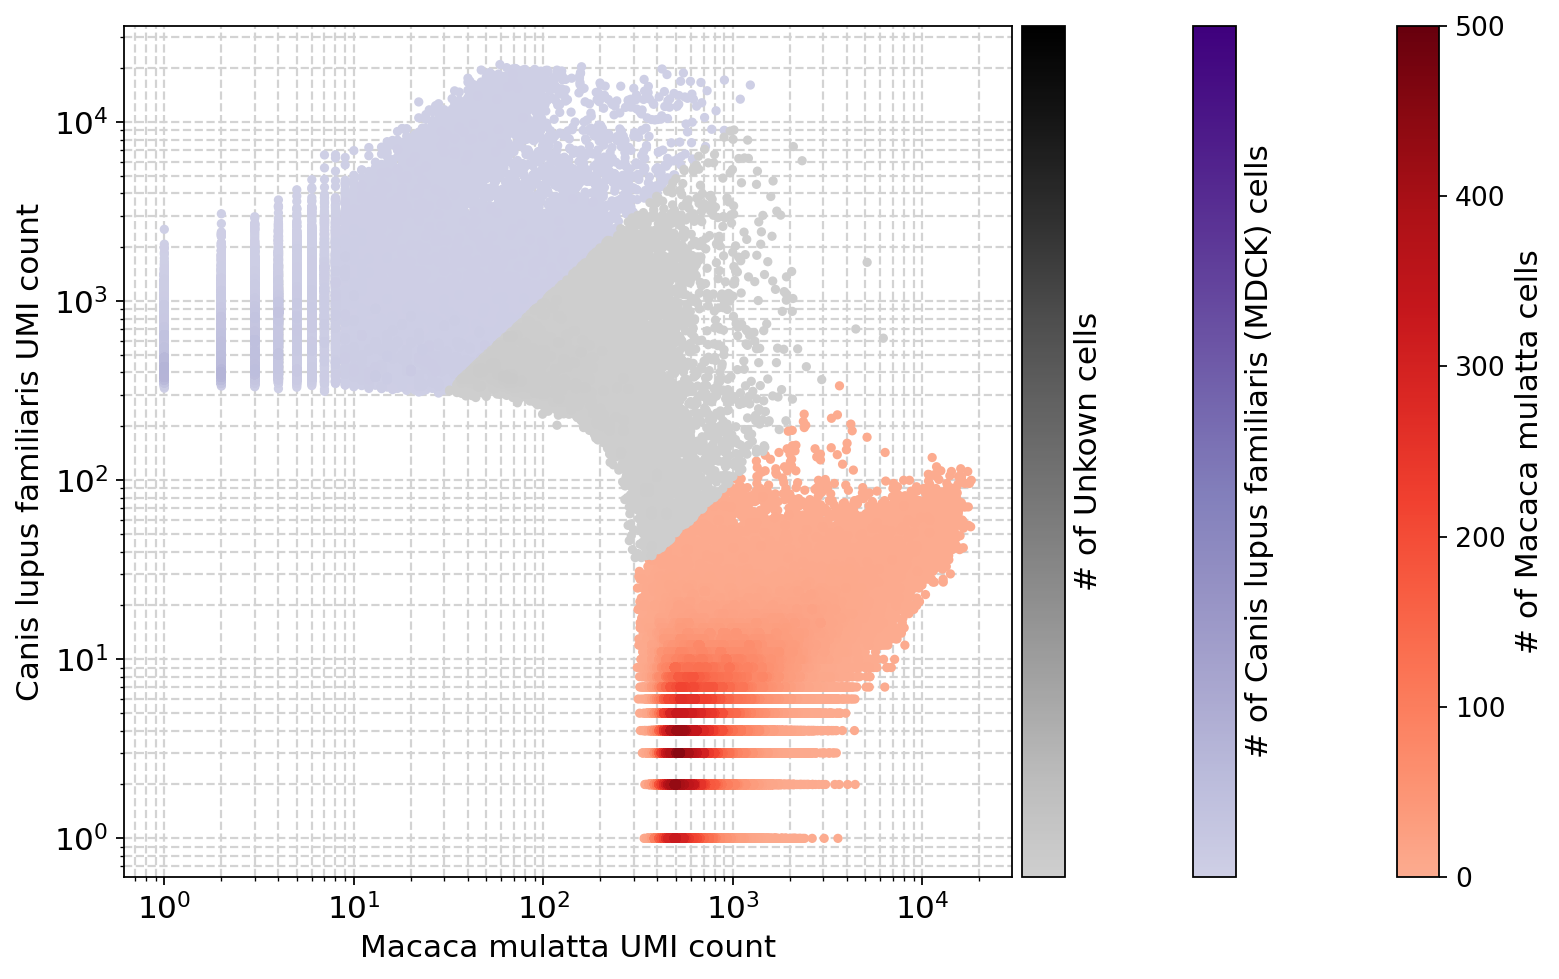

In [55]:
%%time
fig, ax = plt.subplots(figsize=(12, 7))

# Plot number of canis over macaque UMIs

# Generate colormaps (removing lightest values for visibility)
cmaps_orig = [plt.cm.Reds, plt.cm.Purples, plt.cm.Greys]
min_val, max_val = 0.3, 1.0
n = 10
cmaps = []
for orig_cmap in cmaps_orig:
    colors = orig_cmap(np.linspace(min_val, max_val, n))
    cmaps.append(mpl.colors.LinearSegmentedColormap.from_list("mycmap", colors))

for i, species in enumerate(host_adata.obs["species"].unique()):
    indx = host_adata.obs["species"] == species
    # Plot number of canis over macaque UMIs
    x = macaque_count[indx]
    y = canis_count[indx]

    # Histogram data to show point density
    bins = [1500, 1500]
    hh, locx, locy = np.histogram2d(x, y, bins=bins)
    z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
    idx = z.argsort()
    x2, y2, z2 = x[idx], y[idx], z[idx]

    scatter = ax.scatter(x2, y2, c=z2, norm=mpl.colors.Normalize(vmin=0, vmax=500), cmap=cmaps[i], s=10)

    # Add colorbar
    cbar = fig.colorbar(scatter, ax=ax, pad=0.01)
    if i == 0:
        cbar.ax.tick_params(axis="both", labelsize=fontsize-2)
    else:
        cbar.set_ticks([])
    if species == "canis_lupus_familiaris":
        cbar.ax.set_ylabel(f"# of {' '.join(species.capitalize().split('_'))} (MDCK) cells")
    else:
        cbar.ax.set_ylabel(f"# of {' '.join(species.capitalize().split('_'))} cells")

# ax.set_title("Total UMI counts for each cell", fontsize=fontsize+2)
ax.set_xlabel("Macaca mulatta UMI count", fontsize=fontsize)
ax.set_ylabel("Canis lupus familiaris UMI count", fontsize=fontsize)

ax.set_xscale("log")
ax.set_yscale("log")

# Change fontsize of tick labels
ax.tick_params(axis="both", labelsize=fontsize)

ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
ax.set_axisbelow(True)

# Save figure
fig.savefig(
    f"figures/3.1_canis_macaca_umis.png", dpi=300, bbox_inches="tight"
)

fig.show()

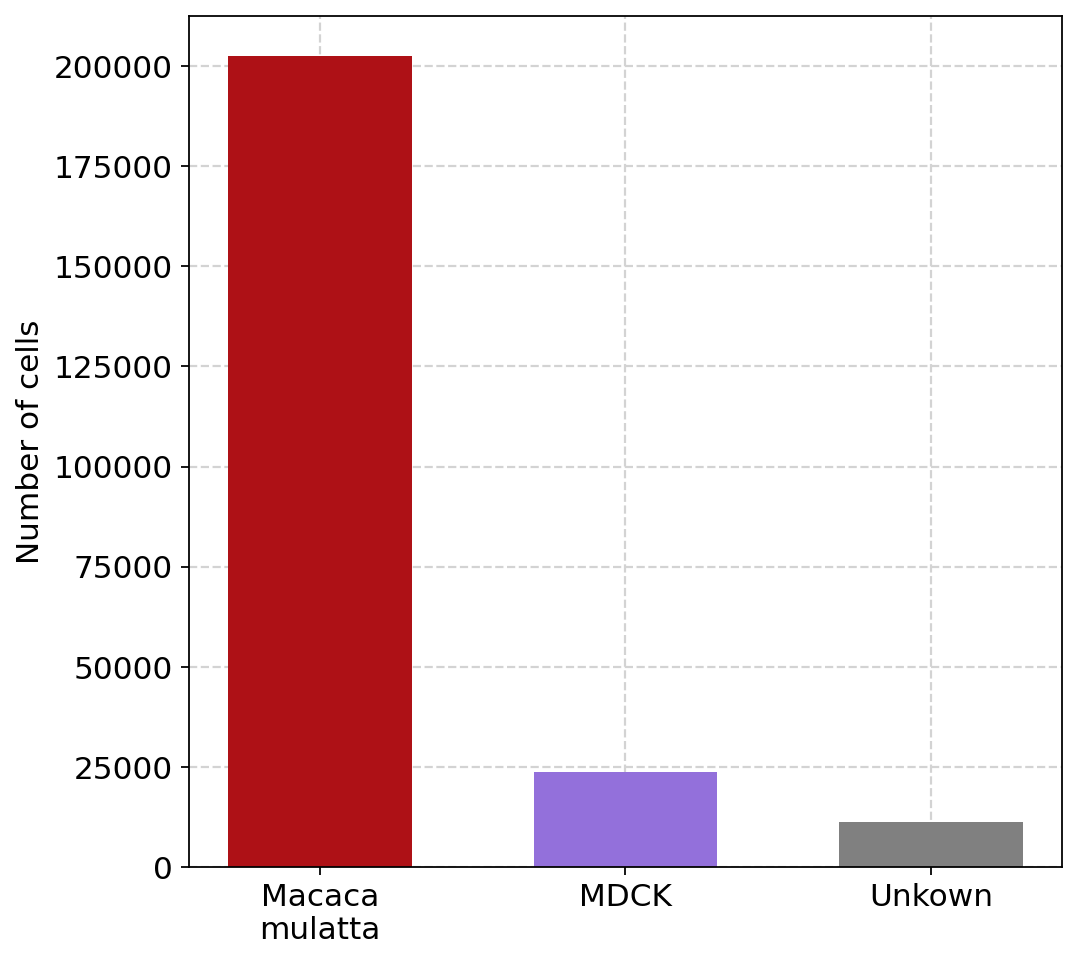

In [59]:
fig, ax = plt.subplots(figsize=(7,7))
width = 0.6

species = ["macaca_mulatta", "canis_lupus_familiaris", "unkown"]
labels = ["Macaca\nmulatta", "MDCK", "Unkown"]

ax.bar(0, len(host_adata.obs[host_adata.obs["species"] == species[0]]), width=width, color="#ae1116")
ax.bar(1, len(host_adata.obs[host_adata.obs["species"] == species[1]]), width=width, color="mediumpurple")
ax.bar(2, len(host_adata.obs[host_adata.obs["species"] == species[2]]), width=width, color="grey")

ax.set_ylabel("Number of cells", fontsize=fontsize)
ax.set_xticks([0,1,2], labels, fontsize=fontsize)

# Change fontsize of tick labels
ax.tick_params(axis="both", labelsize=fontsize)

ax.grid(True, which="both", color="lightgray", ls="--", lw=1)
ax.set_axisbelow(True)

# Save figure
fig.savefig(
    f"figures/3.1_canis_macaca_umis_bars.png", dpi=300, bbox_inches="tight"
)

fig.show()

___

In [79]:
# Save filtered adata object
host_adata.write(f"{fastq_folder}/full_index/host_QC.h5ad")